In [1]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

/Users/yogai/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Encoder

In [3]:
batch_size = 100
original_dim = 784 # 28x28 MNIST| digits
latent_dim = 2
intermediate_dim = 256

In [4]:
from tensorflow.keras.layers import Input, Dense

x = Input(batch_shape=(batch_size, original_dim)) # 入力
h = Dense(intermediate_dim, activation='relu')(x) # Encoderの層
z_mean = Dense(latent_dim)(h) # 潜在変数の平均 μ
z_log_var = Dense(latent_dim)(h) #潜在変数の分散 σのlog

Instructions for updating:
Colocations handled automatically by placer.


# 潜在変数

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

# 潜在変数のサンプリング
# 平均と分散を受けて、潜在変数をサンプリングします。
# z = μ + εΣ
# εは標準正規分布
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

In [6]:
# Lambdaを使って式をwrap
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder

In [7]:
from tensorflow.keras.layers import Dense

decoder_h = Dense(intermediate_dim, activation='relu') # Decoderの中間層
decoder_x = Dense(original_dim, activation='sigmoid') # 出力を行うDecoderの層
h_decoded = decoder_h(z)
x_decoded = decoder_x(h_decoded)

# Loss

In [8]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import metrics

class CustomVariationalLayer(Layer): # Layer classの継承
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded) # 復元誤差: Reconstruction Error
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # 正則化項: KL Divergence
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs) # Layer class のadd_lossを利用
        return x # 実質的には出力は利用しない

In [9]:
from tensorflow.keras.models import Model

y = CustomVariationalLayer()([x, x_decoded])
vae = Model(x, y) # xをinputにyを出力, 出力は実質関係ない
vae.compile(optimizer='rmsprop', loss=None) # CustomVariationalLayerで追加したLossを利用するのでここでのlossはNoneとする

# 学習

In [10]:
x_train, x_test, _, _ = load_mnist(dim=1) # 1次元のmnist dataを読み込む (batch size) x 784

In [11]:
vae.fit(x_train, shuffle=True, epochs=50, batch_size=batch_size, validation_data=(x_test, None), verbose=2)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 8s - loss: 189.3205 - val_loss: 171.0729
Epoch 2/50
 - 8s - loss: 168.0492 - val_loss: 165.7764
Epoch 3/50
 - 6s - loss: 164.2353 - val_loss: 162.7936
Epoch 4/50
 - 5s - loss: 162.0157 - val_loss: 161.5894
Epoch 5/50
 - 6s - loss: 160.4450 - val_loss: 160.2066
Epoch 6/50
 - 5s - loss: 159.1413 - val_loss: 159.0106
Epoch 7/50
 - 6s - loss: 157.9427 - val_loss: 157.8083
Epoch 8/50
 - 7s - loss: 156.8399 - val_loss: 156.6561
Epoch 9/50
 - 8s - loss: 155.8390 - val_loss: 155.8858
Epoch 10/50
 - 7s - loss: 154.9483 - val_loss: 154.9283
Epoch 11/50
 - 6s - loss: 154.1657 - val_loss: 154.2767
Epoch 12/50
 - 6s - loss: 153.4823 - val_loss: 153.7021
Epoch 13/50
 - 7s - loss: 152.9177 - val_loss: 153.5375
Epoch 14/50
 - 6s - loss: 152.4269 - val_loss: 152.9562
Epoch 15/50
 - 6s - loss: 151.9730 - val_loss: 152.3906
Epoch 16/50
 - 6s - loss: 151.5663 - val_loss: 152.2321
Epoch 17/50
 - 

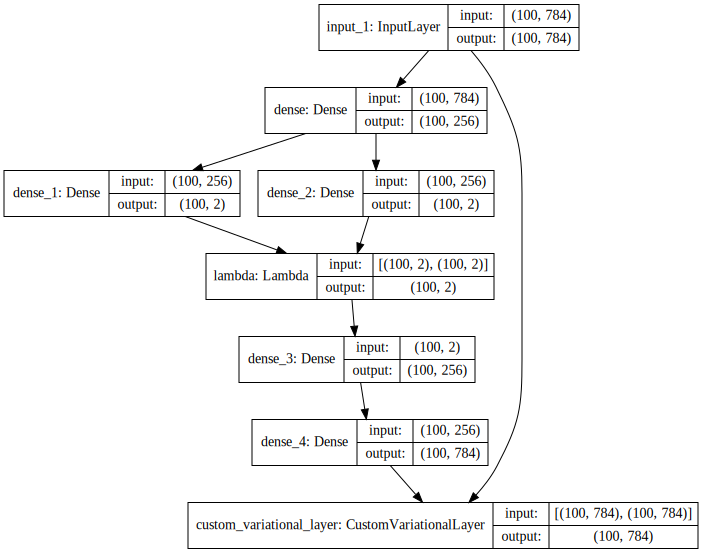

In [14]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

# 生成

In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# 入力として潜在変数を入れられるようにする
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded = decoder_x(_h_decoded)
generator = Model(decoder_input, _x_decoded)

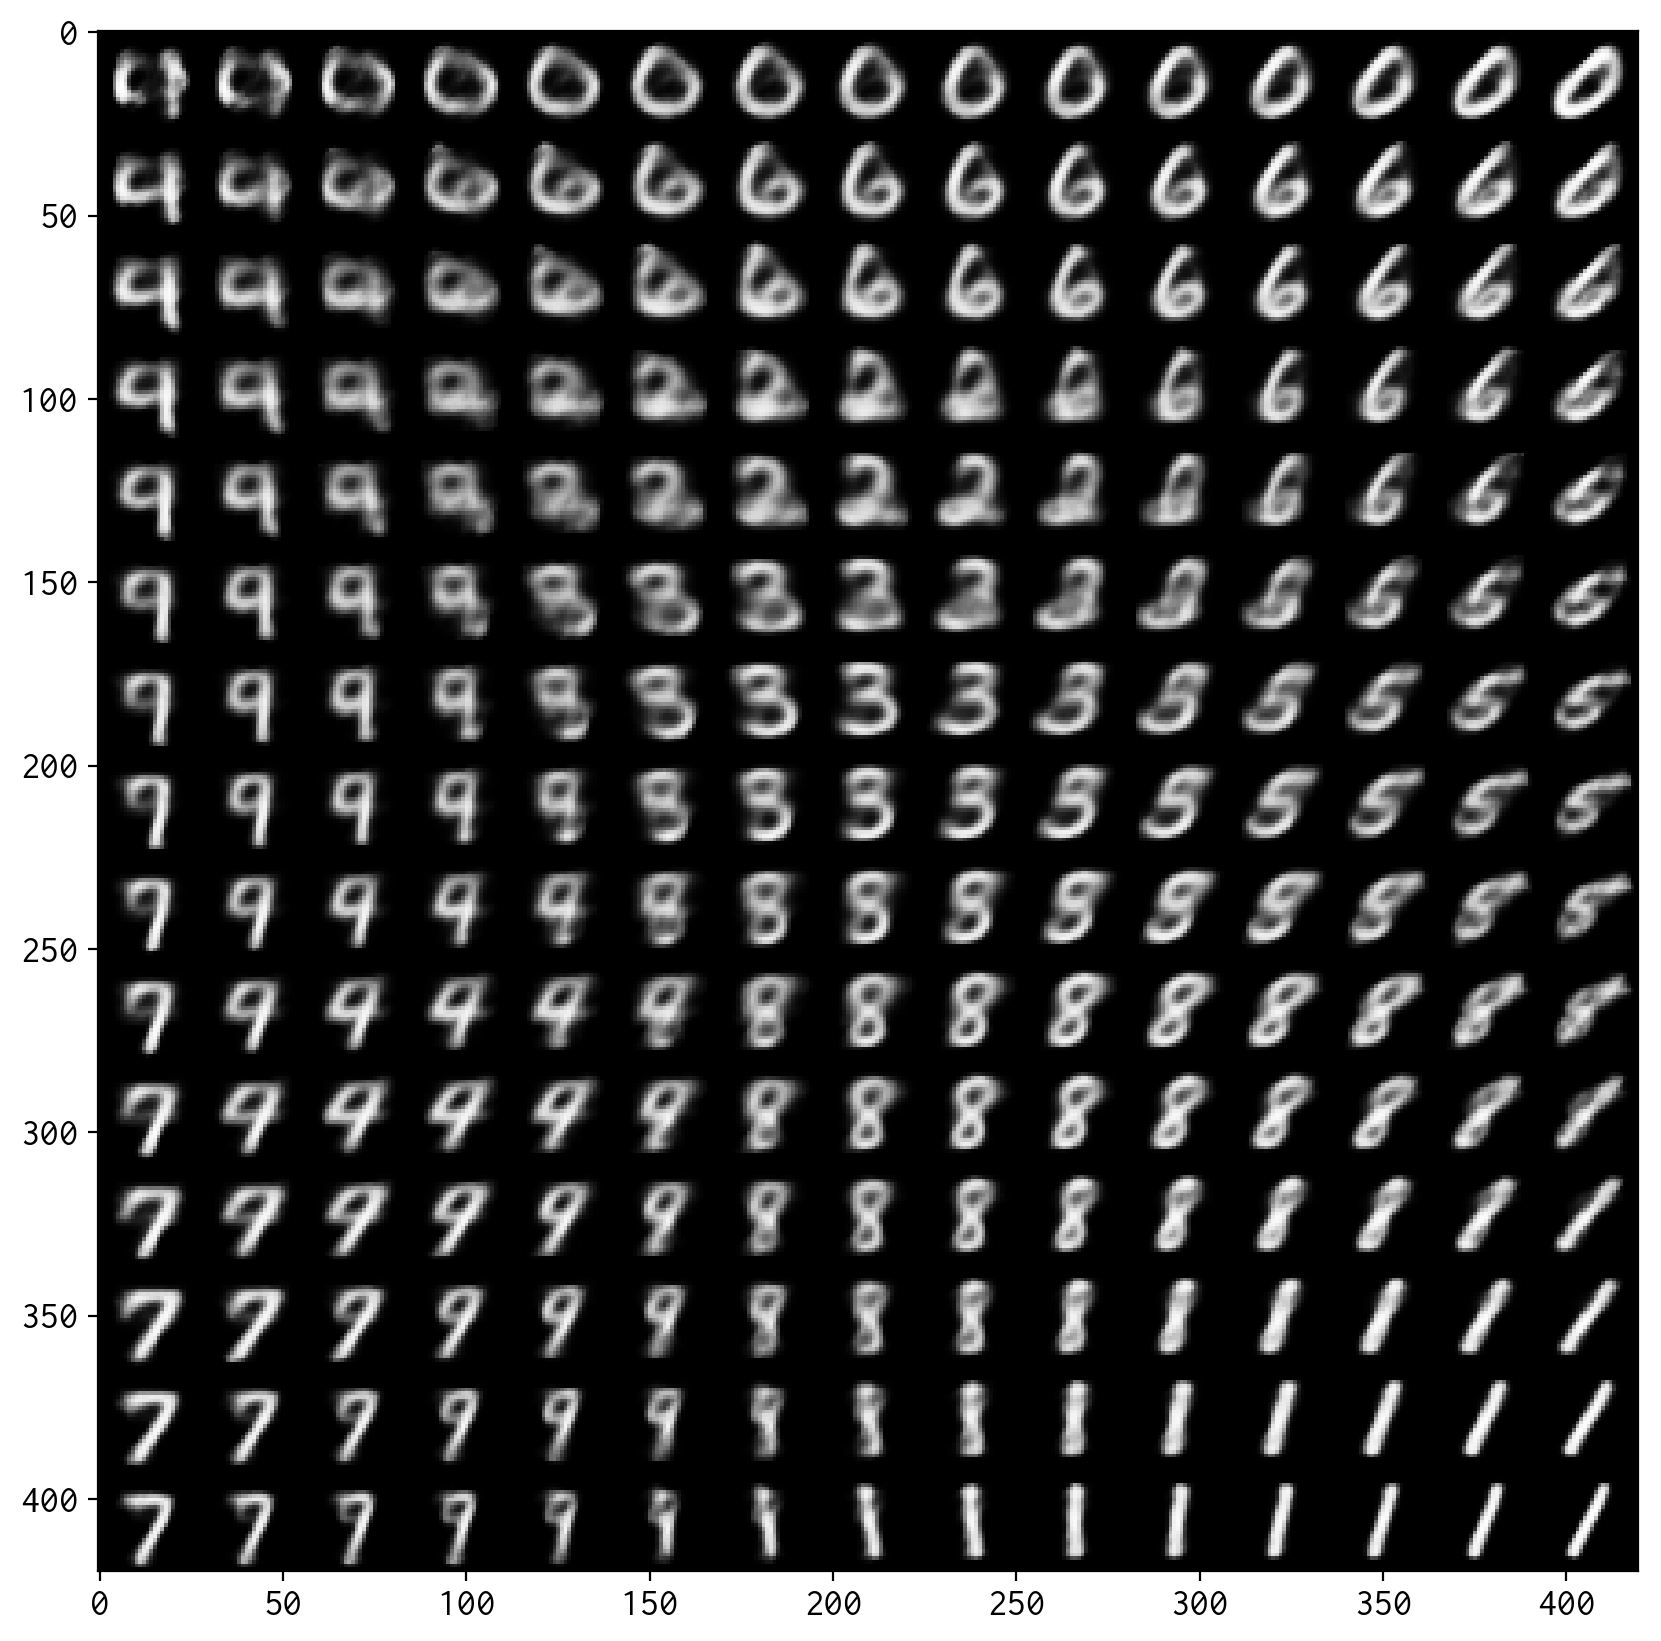

In [16]:
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# ppf: パーセント点関数

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample) # generatorに指定した潜在変数を入れて出力をみる（この出力が新たに生成された文字にあたる）
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()